In [1]:
import os
import glob

cars_paths = []
no_cars_paths = []

cars_paths.extend(glob.glob('vehicles/*/*.png'))
no_cars_paths.extend(glob.glob('non-vehicles/*/*.png'))

In [2]:
print ('Number of non-cars: ', len(no_cars_paths))

Number of non-cars:  8977


In [3]:
print ('Number of cars: ', len(cars_paths))

Number of cars:  8792


In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog


# Define the feature extractor

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, color_space='HSV'):
    #print("converting to color space: ", color_space)
    if (color_space == 'RGB'):
        #print("is this RGB")
        return img
    color_conversion = {
       'HSV' : cv2.COLOR_RGB2HSV,
       'LUV' : cv2.COLOR_RGB2LUV,
       'HLS' : cv2.COLOR_RGB2HLS,
       'YUV' : cv2.COLOR_RGB2YUV,
       'YCrCb' : cv2.COLOR_RGB2YCrCb
       }

    #print("gonna do it")
    return cv2.cvtColor(img, color_conversion[color_space]).astype(np.float32)/255
    

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        feature_image = mpimg.imread(file)
#        feature_image = img.astype(np.float32)/255
        file_features = single_img_features(feature_image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

# Define a function to extract features from an image
# Have this function call bin_spatial() and color_hist()
def single_img_features(feature_image, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = []
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(feature_image, color_space)
    #feature_image = feature_image.astype(np.float32)/255
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Train the classifier
I wanted to be conservative here and I started with just the S channel and 24 bin sizes.
But then I wanted to maximize the accuracy and got 0.989 at bin 32 all channels and 9 hog orientations.
Will scale down to get more performace if needed.

In [6]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
#Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'HSV' 
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 52    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [7]:
#test that extract features works
test = extract_features(cars_paths[:1], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [8]:
car_features = extract_features(cars_paths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(no_cars_paths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (16, 16) and 52 histogram bins
Feature vector length: 7980
4.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9879
My SVC predicts:  [ 1.  0.  0.  0.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  1.  1.  0.  0.]
0.00347 Seconds to predict 10 labels with SVC


In [9]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        #print(np.amax(test_img)) #verified that samples from videos range <-1,1>    
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform((np.array(features).reshape(1, -1)))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(177, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def sliding_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.25, 0.25)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    x_step_size = np.int(xy_window[0] * xy_overlap[0])
    y_step_size = np.int(xy_window[1] * xy_overlap[1])
    # Compute the number of windows in x/y
    x_windows_num = np.int((x_span - x_step_size) / x_step_size)
    y_windows_num = np.int((y_span - y_step_size) / y_step_size)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for y in range(y_windows_num):    
        # Calculate each window position
        pos_y = np.int(y * y_step_size) + y_start_stop[0] 
        for x in range(x_windows_num):    
            pos_x = np.int(x * x_step_size) + x_start_stop[0] 
            # Append window position to list
            window_list.append(((pos_x, pos_y), (pos_x + xy_window[0], pos_y + xy_window[1])))
    # Return the list of windows
    return window_list


# Define the function that processes frames

In [10]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_labeled_bboxes_vat(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_w, bbox_h = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
        if bbox[0][1] <= 300:
            continue
        if bbox[0][1] >= 600:
            continue
        if bbox[0][0] >= 1220:
            continue
        bbox_area = bbox_w * bbox_h
        if bbox_area <= 2500:
            continue
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars(image, box_list, heat_threshold):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

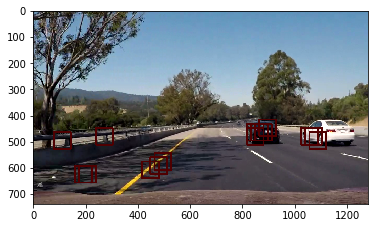

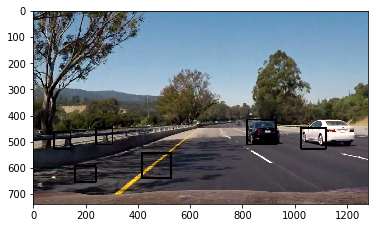

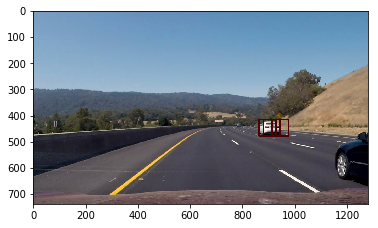

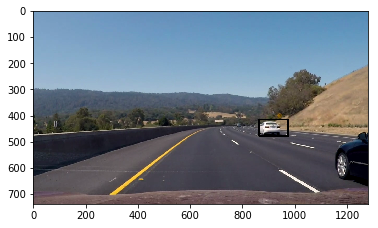

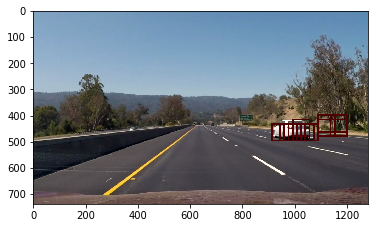

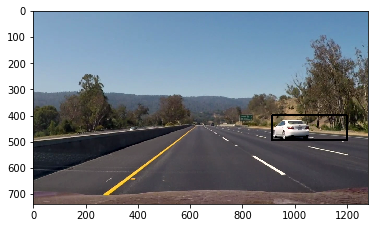

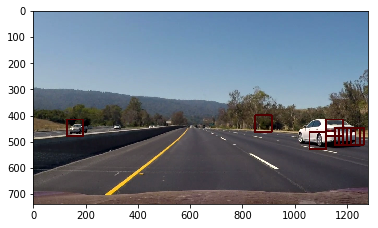

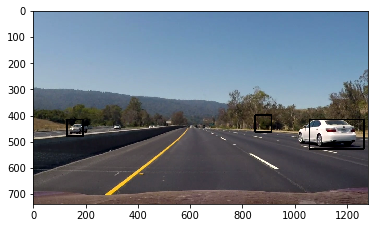

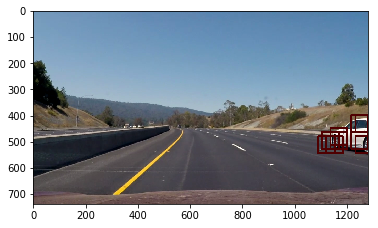

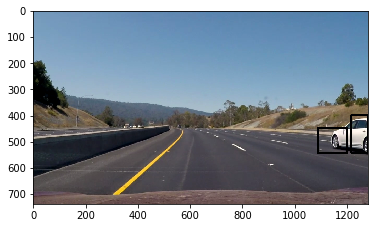

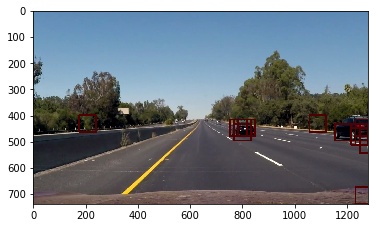

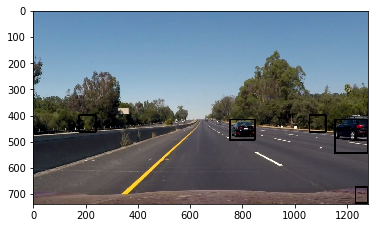

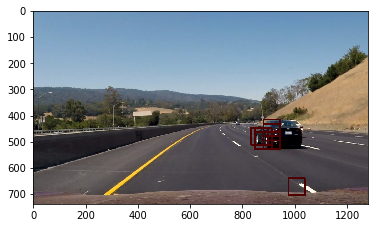

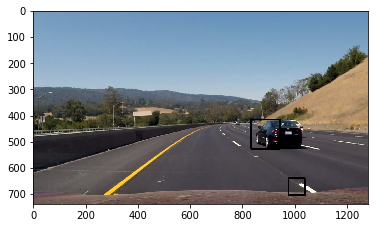

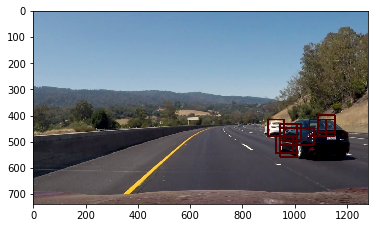

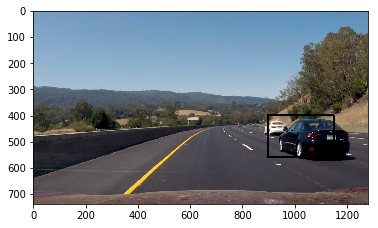

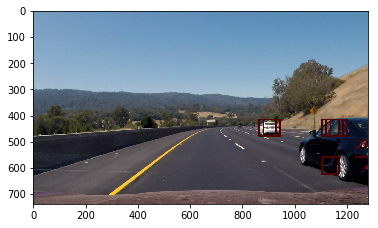

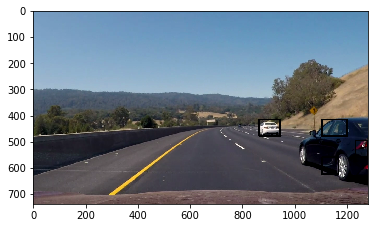

In [11]:
params = dict()
params['color_space'] = color_space
params['nbins'] = hist_bins
params['bins_range'] = (0, 256)
params['resize_image_size'] = spatial_size
params['orient'] = orient
params['pixels_per_cell'] = pix_per_cell
params['cells_per_block'] = cell_per_block

%matplotlib inline
for i in range(15, 6, -1):
    img = mpimg.imread('test_images/test'+ str(i) +'.png')
    sliding_windows = sliding_window(img, y_start_stop = [400, 710], xy_window=(64, 64))
    
    hit_windows = search_windows(img, sliding_windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    out_img = draw_boxes(img, hit_windows)
    fig = plt.figure()
    plt.imshow(out_img)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    add_heat(heatmap, hit_windows)
    labels = label(heatmap)
    #apply_threshold(heatmap, 2)
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    fig = plt.figure()
    plt.imshow(final_image)


# Play around with different scaling options to see what makes sense

test_images/test7.png
test_images/test7.png
test_images/test8.png
test_images/test8.png
test_images/test9.png
test_images/test9.png
test_images/test10.png
test_images/test10.png
test_images/test11.png
test_images/test11.png
test_images/test12.png
test_images/test12.png


/home/bercik/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


test_images/test13.png
test_images/test13.png
test_images/test14.png
test_images/test14.png
test_images/test15.png
test_images/test15.png


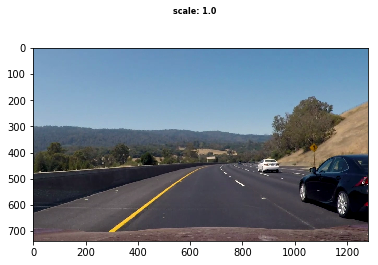

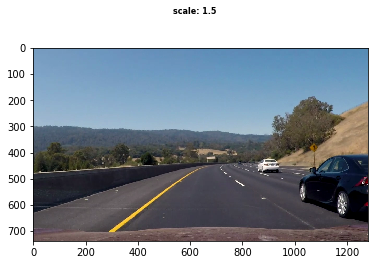

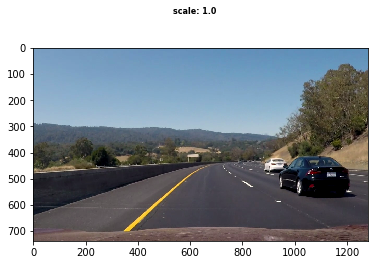

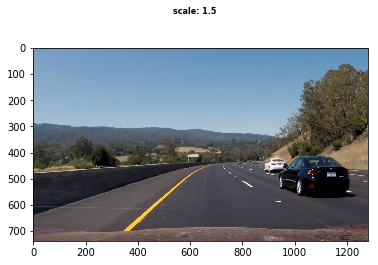

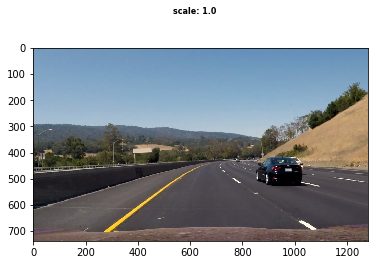

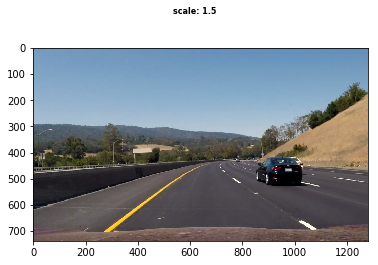

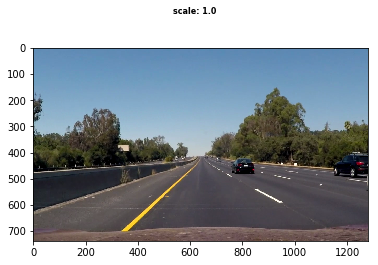

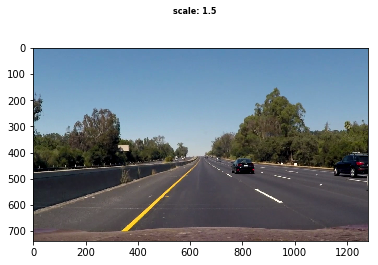

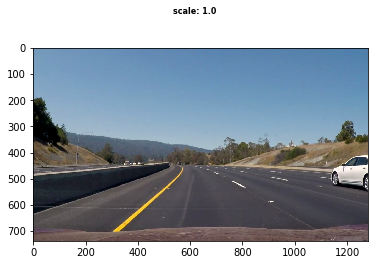

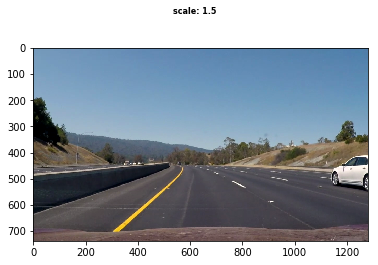

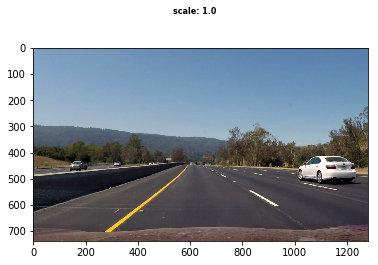

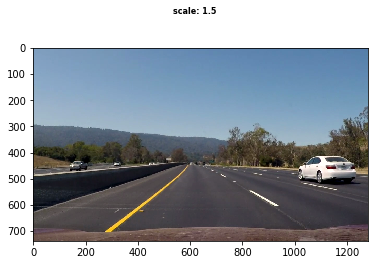

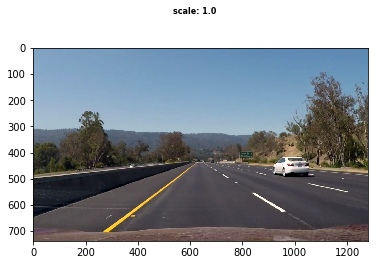

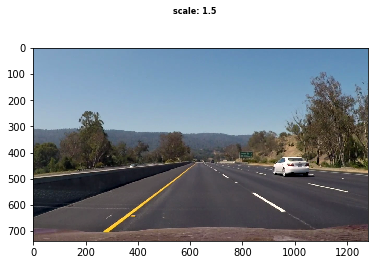

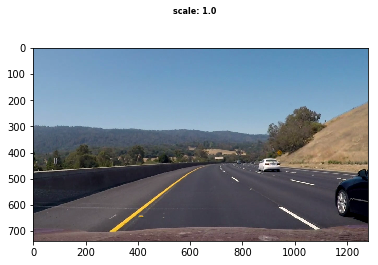

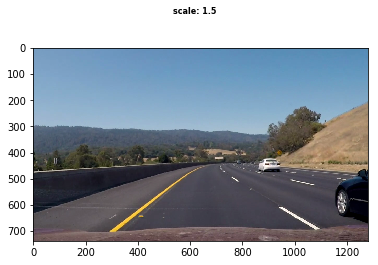

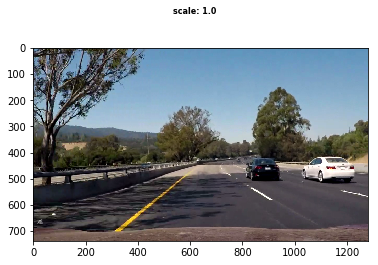

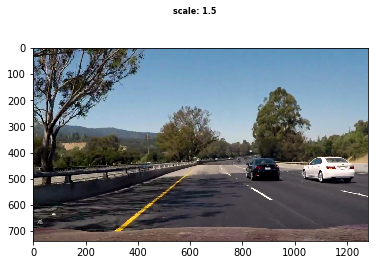

In [12]:
#define 3 ranges of search
#ystart, ystop, scale
ranges = [(410, 660, 1.0), (440, 720, 1.5)]
#[
#    (380, 530, 1.0),
#    (400, 600, 1.9),
#    (500, 700, 2.3)
#]
xstart = 640
xstop = 1280

%matplotlib inline
for i in range(7, 16, 1):
    path = 'test_images/test'+ str(i) +'.png'
    img1 = np.copy(mpimg.imread(path))
    for ystart, ystop, scale in ranges:
        print(path)
        fig = plt.figure()
        fig.suptitle('scale: '+ str(scale), fontsize=8, fontweight='bold')
        #print (ystart, ystop, scale)
        #bboxes = find_bboxes(img1, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        plt.imshow(img1)
        plt.figure()


In [16]:
import time
time_boxes = []
the_grid = None
prev_hit_windows = None
pre_convert = None

def pipeline(irrw):
    global time_boxes
    global xstart
    global xstop
    global the_grid
    global prev_hit_windows
    global pre_convert
    
    imgog = np.copy(irrw)
    if (pre_convert is None):
        pre_convert = np.amax(imgog) > 1
    
    if (pre_convert):
        imgog = imgog.astype(np.float32)/255

    frames_lookback = 5
    heat_threshold = 10
    
    if (the_grid == None):
        the_grid = sliding_window(imgog, y_start_stop = (420, 700), xy_window=(64, 64))
        the_grid += sliding_window(imgog, y_start_stop = (420, 700), xy_window=(96, 96))
        the_grid += sliding_window(imgog, y_start_stop = (420, 700), xy_window=(128, 128))
    
    hit_windows = search_windows(imgog, the_grid, svc, X_scaler, color_space=color_space, 
                spatial_size=spatial_size, hist_bins=hist_bins, 
                hist_range=(0, 256), orient=orient, 
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                hog_channel=hog_channel, spatial_feat=True, 
                hist_feat=True, hog_feat=True)

    all_bboxes = hit_windows

   # if prev_hit_windows != None:
   #     all_bboxes += prev_hit_windows
        
    prev_hit_windows = hit_windows
    
    
    heatmap = np.zeros_like(imgog[:,:,0]).astype(np.float)
    add_heat(heatmap, all_bboxes)
    
    apply_threshold(heatmap, 3)
    labels = label(heatmap)
    final_image = draw_labeled_bboxes(np.copy(imgog), labels)
    plt.imshow(final_image)
    return final_image

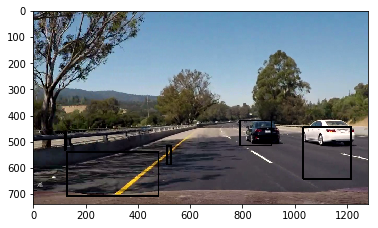

In [17]:
plt.figure()
path = 'test_images/test15.png'
img1 = np.copy(mpimg.imread(path))
plt.imshow(pipeline(img1))


[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


 97%|█████████▋| 38/39 [05:07<00:08,  8.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 5min 6s, sys: 144 ms, total: 5min 6s
Wall time: 5min 8s


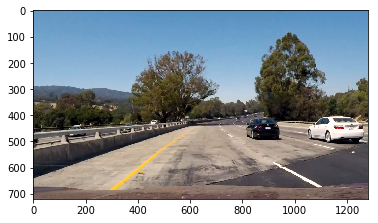

In [15]:
from moviepy.editor import VideoFileClip
white_output = 'project_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

#### 